<a href="https://colab.research.google.com/github/kirank981/Project_space/blob/main/project_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependences


Install the necessary packages for PyTorch (torch and torchvision) and Flower (flwr) and pandas

In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib pandas

Import everything we need

In [45]:
from collections import OrderedDict
from typing import List, Tuple

from google.colab import drive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import CIFAR10



from sklearn.model_selection import train_test_split  # Import the train_test_split function
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

!pip install catboost
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# from tensorflow.keras.layers import Conv2D, Multiply, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Multiply

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


# Loading the data

Mounting drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting the path to the location of the file

In [4]:
# Define the path to daily dataset folder
daily_dataset_path = Path('/content/drive/MyDrive/Federated learning implementation/dataset/dataset_archive/daily_dataset/daily_dataset')

# Define the path to daily dataset folder
weather_daily_dataset_path = Path('/content/drive/MyDrive/Federated learning implementation/dataset/dataset_archive/weather_daily_dataset.csv')


## Loading daily data
(of energy consumption)


In [5]:

# Initializing list to store dataframes
dfs = []

# Loop through the CSV files and reading them into dataframes
for i in range(1):
    filename = f'block_{i}.csv'
    df = pd.read_csv(daily_dataset_path / filename)
    dfs.append(df)

# Concatenating all the dataframes into a single dataframe
energy_daily_data = pd.concat(dfs, ignore_index=True)

# NRATM(Not Required At The Moment)
# # Group the data by LCLid and create a dictionary of dataframes
# grouped_data = dict(tuple(energy_daily_data.groupby('LCLid')))


Loading data using file name

In [6]:
# Loading data from a specific CSV file
specific_file_data = pd.read_csv(daily_dataset_path / 'LCLid_3nos.csv')

# Displaying data
print(specific_file_data)

          LCLid         day  energy_median  energy_mean  energy_max  \
0     MAC000002  2012-10-12         0.1385     0.154304       0.886   
1     MAC000002  2012-10-13         0.1800     0.230979       0.933   
2     MAC000002  2012-10-14         0.1580     0.275479       1.085   
3     MAC000002  2012-10-15         0.1310     0.213688       1.164   
4     MAC000002  2012-10-16         0.1450     0.203521       0.991   
...         ...         ...            ...          ...         ...   
1316  MAC000246  2014-02-23         0.4850     0.619083       1.644   
1317  MAC000246  2014-02-24         0.1245     0.394479       2.643   
1318  MAC000246  2014-02-25         0.2870     0.494104       2.205   
1319  MAC000246  2014-02-26         0.2570     0.324208       1.158   
1320  MAC000246  2014-02-27         0.1365     0.333875       2.436   

      energy_count  energy_std  energy_sum  energy_min  
0               46    0.196034       7.098       0.000  
1               48    0.192329   

### Loading required data
Creating a DataFrame that have only the required data

In [7]:
selected_column = ['LCLid','energy_sum','day']
# energy_daily_selected=energy_daily_data[selected_column] (check)
energy_daily_selected=specific_file_data[selected_column]
# print(energy_daily_selected)

# Group the data by LCLid and create a dictionary of dataframes, allowing to access each dataframe separately using the LCLid as the key
grouped_data_selected = dict(tuple(energy_daily_selected.groupby('LCLid')))
# Display the data for 'MAC000002'
print('\n')
print('Data report of MAC000002')
print(grouped_data_selected['MAC000002'])




Data report of MAC000002
         LCLid  energy_sum         day
0    MAC000002       7.098  2012-10-12
1    MAC000002      11.087  2012-10-13
2    MAC000002      13.223  2012-10-14
3    MAC000002      10.257  2012-10-15
4    MAC000002       9.769  2012-10-16
..         ...         ...         ...
498  MAC000002      14.886  2014-02-23
499  MAC000002      12.528  2014-02-24
500  MAC000002      11.826  2014-02-25
501  MAC000002      12.328  2014-02-26
502  MAC000002      20.518  2014-02-27

[503 rows x 3 columns]


## Loading daily weather data

Creating a 'day' column that stores only the date values from 'time' column
(for linking weather dataset 'day' with daily dataset 'day')

In [8]:
# Load the weather dataset into a DataFrame
weather_daily_data = pd.read_csv(weather_daily_dataset_path)

# Convert the 'time' column to datetime format
weather_daily_data['time'] = pd.to_datetime(weather_daily_data['time'])

# Calculate the mean temperature for each day and store it in a new column 'mean_temp'
weather_daily_data['mean_temp'] = (weather_daily_data['temperatureMax'] + weather_daily_data['temperatureMin']) / 2

# Print the updated DataFrame
print(weather_daily_data)

     temperatureMax   temperatureMaxTime  windBearing                 icon  \
0             11.96  2011-11-11 23:00:00          123                  fog   
1              8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2             10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3              8.07  2011-12-02 23:00:00          232                 wind   
4              8.22  2011-12-24 23:00:00          252  partly-cloudy-night   
..              ...                  ...          ...                  ...   
877            9.03  2014-01-26 16:00:00          233    partly-cloudy-day   
878           10.31  2014-02-27 14:00:00          224    partly-cloudy-day   
879           18.97  2014-03-09 14:00:00          172  partly-cloudy-night   
880            8.83  2014-02-12 16:00:00          210                 wind   
881            9.90  2014-02-15 12:00:00          233                 wind   

     dewPoint   temperatureMinTime  cloudCover  windSpeed  pres

### Loading required data
Creating a DataFrame that have only the required data

In [9]:
# Create a new DataFrame with selected columns
selected_columns = ['mean_temp', 'pressure', 'humidity', 'windSpeed', 'time']
weather_selected = weather_daily_data[selected_columns]

# Print the new dataset
print(weather_selected)

     mean_temp  pressure  humidity  windSpeed       time
0       10.405   1016.08      0.95       3.88 2011-11-11
1        5.535   1007.71      0.88       3.94 2011-12-11
2        9.180   1032.76      0.74       3.54 2011-12-27
3        5.315   1012.12      0.87       3.00 2011-12-02
4        5.695   1028.17      0.80       4.46 2011-12-24
..         ...       ...       ...        ...        ...
877      6.145   1002.10      0.79       4.55 2014-01-26
878      7.120   1007.02      0.74       4.14 2014-02-27
879     13.310   1022.44      0.58       2.78 2014-03-09
880      5.930    994.27      0.75       7.24 2014-02-12
881      7.640    988.63      0.69       9.96 2014-02-15

[882 rows x 5 columns]


# Dataset with Household energy consumption values and weather values

## For all households

In [10]:
# Convert 'time' column in weather_selected to datetime objects
weather_selected['time'] = pd.to_datetime(weather_selected['time'])

# Create a list to store the merged data DataFrames
merged_data_list = []

# Iterate through each LCLid in energy_daily_selected
for lclid, data in grouped_data_selected.items():
    # Convert 'day' column in current LCLid data to datetime objects
    data['day'] = pd.to_datetime(data['day'])

    # Merge the current LCLid data with weather_selected based on the common date values
    merged_data_lclid = pd.merge(weather_selected, data, left_on='time', right_on='day', how='inner')

    # Drop the redundant 'day' column from the merged data
    merged_data_lclid.drop(columns=['day'], inplace=True)

    # Append the merged data to the merged_data_list
    merged_data_list.append(merged_data_lclid)

# Concatenate the merged data DataFrames in the list
merged_data = pd.concat(merged_data_list, ignore_index=True)

# Display the merged dataset
print(merged_data)


     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0       10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1       12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2        7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3        5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4        4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
..         ...       ...       ...        ...        ...        ...   
662      4.470   1001.76      0.91       1.52 2014-01-30  MAC000246   
663      6.145   1002.10      0.79       4.55 2014-01-26  MAC000246   
664      7.120   1007.02      0.74       4.14 2014-02-27  MAC000246   
665      5.930    994.27      0.75       7.24 2014-02-12  MAC000246   
666      7.640    988.63      0.69       9.96 2014-02-15  MAC000246   

     energy_sum  
0        10.545  
1        11.221  
2        12.209  
3        11.663  
4        13.248  
..          ...  
662      22.531  
663

<ipython-input-10-fc90630300b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_selected['time'] = pd.to_datetime(weather_selected['time'])


## For one household

In [11]:
print(merged_data[merged_data['LCLid'] == "MAC000002"])

     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0       10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1       12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2        7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3        5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4        4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
..         ...       ...       ...        ...        ...        ...   
271      4.470   1001.76      0.91       1.52 2014-01-30  MAC000002   
272      6.145   1002.10      0.79       4.55 2014-01-26  MAC000002   
273      7.120   1007.02      0.74       4.14 2014-02-27  MAC000002   
274      5.930    994.27      0.75       7.24 2014-02-12  MAC000002   
275      7.640    988.63      0.69       9.96 2014-02-15  MAC000002   

     energy_sum  
0        10.545  
1        11.221  
2        12.209  
3        11.663  
4        13.248  
..          ...  
271      14.166  
272

# Splitting dataset to training and testing sets



## Preprocessing dataset

### Counting amount of data for each LCLid (data available for each household)

In [12]:
# Convert 'time' column in weather_selected to datetime objects
weather_selected['time'] = pd.to_datetime(weather_selected['time'])

# Merge the data into merged_data DataFrame as described in your previous code

# Count the number of data rows for each LCLid
lclid_data_counts = merged_data['LCLid'].value_counts()

# Display the counts for each LCLid
print("Data row counts for each LCLid:")
print(lclid_data_counts)



Data row counts for each LCLid:
MAC000246    391
MAC000002    276
Name: LCLid, dtype: int64


<ipython-input-12-27ee962d4454>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_selected['time'] = pd.to_datetime(weather_selected['time'])


### Identifiting the no of households with insufficient amount of data

In [13]:
# Count the number of data rows for each LCLid
lclid_data_counts = merged_data['LCLid'].value_counts()


# Get the total number of unique LCLid values
total_lclids = len(lclid_data_counts)

# Count the number of LCLid values with less than 100 data rows
count_less_than_100 = (lclid_data_counts < 100).sum()

# Display the count of LCLid values with less than 100 data rows
print("Number of LCLid values with less than 100 data rows:", count_less_than_100)

# Display the total number of unique LCLid values
print("Total number of unique LCLid values:", total_lclids)

Number of LCLid values with less than 100 data rows: 0
Total number of unique LCLid values: 2


### Removing the households with less data, from the dataset

In [14]:
# Get the list of LCLid values with less than 100 data rows
lclids_to_remove = lclid_data_counts[lclid_data_counts < 100].index

# Remove rows corresponding to LCLid values with less than 100 data rows
filtered_data = merged_data[~merged_data['LCLid'].isin(lclids_to_remove)]

# also removing rows with NaN values in the dataset
filtered_data = filtered_data.dropna()

# Display the filtered data
print(filtered_data)

     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0       10.000   1001.79      0.81       6.54 2012-11-25  MAC000002   
1       12.170   1008.74      0.90       5.74 2012-11-20  MAC000002   
2        7.830    979.63      0.85       4.07 2012-11-01  MAC000002   
3        5.295   1020.29      0.87       3.58 2012-11-06  MAC000002   
4        4.650   1001.72      0.80       5.63 2012-12-07  MAC000002   
..         ...       ...       ...        ...        ...        ...   
662      4.470   1001.76      0.91       1.52 2014-01-30  MAC000246   
663      6.145   1002.10      0.79       4.55 2014-01-26  MAC000246   
664      7.120   1007.02      0.74       4.14 2014-02-27  MAC000246   
665      5.930    994.27      0.75       7.24 2014-02-12  MAC000246   
666      7.640    988.63      0.69       9.96 2014-02-15  MAC000246   

     energy_sum  
0        10.545  
1        11.221  
2        12.209  
3        11.663  
4        13.248  
..          ...  
662      22.531  
663

## Splitting the dataset to train and test
 where the split ratio(70:30) is made with every househould's data.

In [15]:
from sklearn.model_selection import train_test_split

# Define the split percentages
train_percentage = 0.6 # 60% for training
val_percentage = 0.3   # 30% for validation
test_percentage = 0.3  # 30% for testing
min_data_points = 10   # Minimum number of data points required for an LCLid

# Create lists to store DataFrames for training, validation, and testing
train_data_list = []
val_data_list = []
test_data_list = []

# Iterate through each unique LCLid and split the data based on train_percentage, val_percentage, and test_percentage
unique_lclids = filtered_data['LCLid'].unique()
for lclid in unique_lclids:
    lclid_data = filtered_data[filtered_data['LCLid'] == lclid]

    # Check if there are sufficient data points for the current LCLid
    if len(lclid_data) >= min_data_points:
        # Split the data for the current LCLid into training, validation, and test sets
        train_data_lclid, remaining_data_lclid = train_test_split(lclid_data, train_size=train_percentage, shuffle=False)
        val_data_lclid, test_data_lclid = train_test_split(remaining_data_lclid, train_size=val_percentage/(val_percentage + test_percentage), shuffle=False)

        # Randomize the rows within each subset
        train_data_lclid = train_data_lclid.sample(frac=1, random_state=42)
        val_data_lclid = val_data_lclid.sample(frac=1, random_state=42)
        test_data_lclid = test_data_lclid.sample(frac=1, random_state=42)

        # Append to the train_data_list, val_data_list, and test_data_list
        train_data_list.append(train_data_lclid)
        val_data_list.append(val_data_lclid)
        test_data_list.append(test_data_lclid)

# Concatenate the DataFrames in the lists
FL_train_set = pd.concat(train_data_list, ignore_index=True)
FL_val_set = pd.concat(val_data_list, ignore_index=True)
FL_test_set = pd.concat(test_data_list, ignore_index=True)

# Store the training, validation, and test sets in separate lists
FL_train_sets_list = train_data_list
FL_val_sets_list = val_data_list
FL_test_sets_list = test_data_list

# Display the training, validation, and test sets
print("Training set:")
print(FL_train_set)
print("Validation set:")
print(FL_val_set)
print("Test set:")
print(FL_test_set)


Training set:
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0        3.140   1012.97      0.83       4.76 2013-01-12  MAC000002   
1        3.200   1019.29      0.78       3.08 2013-02-08  MAC000002   
2        8.050   1033.95      0.89       1.35 2013-11-27  MAC000002   
3        6.260   1018.89      0.80       5.44 2012-12-09  MAC000002   
4        5.900   1015.79      0.79       2.61 2013-11-10  MAC000002   
..         ...       ...       ...        ...        ...        ...   
394     11.210   1003.59      0.86       5.51 2012-12-23  MAC000246   
395      8.580   1010.84      0.81       7.01 2011-12-08  MAC000246   
396      7.755    997.84      0.91       2.38 2012-11-10  MAC000246   
397      4.835   1029.69      0.80       4.25 2013-02-28  MAC000246   
398      4.815   1023.19      0.83       2.14 2012-12-08  MAC000246   

     energy_sum  
0        10.586  
1         9.635  
2        11.003  
3        11.355  
4        25.556  
..          ...  
394    

### For FL training, validation and test sets

In [16]:
# Display the first training set
print("First Training set:")
print(FL_train_sets_list[0])
print("First Validation set:")
print(FL_val_sets_list[0])
print("First Test set:")
print(FL_test_sets_list[0])

First Training set:
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
135      3.140   1012.97      0.83       4.76 2013-01-12  MAC000002   
115      3.200   1019.29      0.78       3.08 2013-02-08  MAC000002   
131      8.050   1033.95      0.89       1.35 2013-11-27  MAC000002   
55       6.260   1018.89      0.80       5.44 2012-12-09  MAC000002   
95       5.900   1015.79      0.79       2.61 2013-11-10  MAC000002   
..         ...       ...       ...        ...        ...        ...   
71       9.480   1037.15      0.85       4.28 2013-01-04  MAC000002   
106      8.145   1005.53      0.90       2.00 2013-11-08  MAC000002   
14       5.745   1014.66      0.82       0.72 2012-11-18  MAC000002   
92       0.780   1020.50      0.63       4.79 2013-02-22  MAC000002   
102      0.775   1008.99      0.85       3.28 2013-01-15  MAC000002   

     energy_sum  
135      10.586  
115       9.635  
131      11.003  
55       11.355  
95       25.556  
..          ...  
7

In [17]:
# Display the first training set
print("First Training set:")
print(FL_train_sets_list[1])
print("First Validation set:")
print(FL_val_sets_list[1])
print("First Test set:")
print(FL_test_sets_list[1])

First Training set:
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
345      1.605   1016.35      0.84       2.10 2012-12-02  MAC000246   
482     10.680   1012.62      0.86       8.91 2013-12-21  MAC000246   
456      5.400   1016.89      0.82       4.00 2013-01-01  MAC000246   
285      4.840   1006.01      0.77       5.57 2011-12-05  MAC000246   
403      9.935    999.12      0.91       4.28 2012-12-24  MAC000246   
..         ...       ...       ...        ...        ...        ...   
382     11.210   1003.59      0.86       5.51 2012-12-23  MAC000246   
290      8.580   1010.84      0.81       7.01 2011-12-08  MAC000246   
368      7.755    997.84      0.91       2.38 2012-11-10  MAC000246   
455      4.835   1029.69      0.80       4.25 2013-02-28  MAC000246   
378      4.815   1023.19      0.83       2.14 2012-12-08  MAC000246   

     energy_sum  
345      27.061  
482      10.588  
456      36.512  
285       6.020  
403      26.337  
..          ...  
3

### Centralised training, validation and test sets

In [18]:

# Copy FL training set to central training set
Central_train_data = FL_train_set.copy()

# Copy FL validation set to central validation set
Central_val_data = FL_val_set.copy()

# Copy FL test set to central test set
Central_test_data = FL_test_set.copy()

# Display the sizes of the sets
print("Central Training set size:", len(Central_train_data))
print("Central Validation set size:", len(Central_val_data))
print("Central Test set size:", len(Central_test_data))



Central Training set size: 399
Central Validation set size: 133
Central Test set size: 135


Displaying training, validation and test sets

In [19]:
# Display the training and test sets
print("Training set:")
print(Central_train_data)
print("Validation set:")
print(Central_val_data)
print("Test set:")
print(Central_test_data)


Training set:
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
0        3.140   1012.97      0.83       4.76 2013-01-12  MAC000002   
1        3.200   1019.29      0.78       3.08 2013-02-08  MAC000002   
2        8.050   1033.95      0.89       1.35 2013-11-27  MAC000002   
3        6.260   1018.89      0.80       5.44 2012-12-09  MAC000002   
4        5.900   1015.79      0.79       2.61 2013-11-10  MAC000002   
..         ...       ...       ...        ...        ...        ...   
394     11.210   1003.59      0.86       5.51 2012-12-23  MAC000246   
395      8.580   1010.84      0.81       7.01 2011-12-08  MAC000246   
396      7.755    997.84      0.91       2.38 2012-11-10  MAC000246   
397      4.835   1029.69      0.80       4.25 2013-02-28  MAC000246   
398      4.815   1023.19      0.83       2.14 2012-12-08  MAC000246   

     energy_sum  
0        10.586  
1         9.635  
2        11.003  
3        11.355  
4        25.556  
..          ...  
394    

# Centralised Training

## Defining features and target column

In [20]:
# Separate features and target variable
Central_X_train = Central_train_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_train = Central_train_data['energy_sum']

# Separate features and target variable
Central_X_val = Central_val_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_val = Central_val_data['energy_sum']

# Separate features and target variable
Central_X_test = Central_test_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_test = Central_test_data['energy_sum']


## Preprocessing (scaler and imputer)

In [21]:
# Define the datasets
datasets = [
    (Central_X_train, Central_y_train, "Central Training"),
    (Central_X_val, Central_y_val, "Central Validation"),
    (Central_X_test, Central_y_test, "Central Test")
]

# Preprocess each dataset
for X, y, name in datasets:
    # Impute missing values and scale features
    X_scaled = StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(X))

    # Display dataset name and shape
    print(f"{name} Dataset:")
    print("Original Shape:", X.shape)
    print("Preprocessed Shape:", X_scaled.shape)
    print()

Central Training Dataset:
Original Shape: (399, 4)
Preprocessed Shape: (399, 4)

Central Validation Dataset:
Original Shape: (133, 4)
Preprocessed Shape: (133, 4)

Central Test Dataset:
Original Shape: (135, 4)
Preprocessed Shape: (135, 4)



In [22]:
# Check for missing values
print(Central_y_train.isnull().sum())
print(Central_X_train.isnull().sum())

# Replace missing values with mean (you can choose another strategy)
Central_y_train.fillna(Central_y_train.mean(), inplace=True)
Central_X_train.fillna(Central_X_train.mean(), inplace=True)

# Check for missing values
print(Central_y_train.isnull().sum())
print(Central_X_train.isnull().sum())

0
mean_temp    0
pressure     0
humidity     0
windSpeed    0
dtype: int64
0
mean_temp    0
pressure     0
humidity     0
windSpeed    0
dtype: int64


<ipython-input-22-e51efdbfd96c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Central_X_train.fillna(Central_X_train.mean(), inplace=True)
<ipython-input-22-e51efdbfd96c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Central_X_train.fillna(Central_X_train.mean(), inplace=True)
<ipython-input-22-e51efdbfd96c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

## Model selection

In [23]:

# # List of models to train
# models = [
#     LinearRegression(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(),
#     GradientBoostingRegressor(),
#     XGBRegressor(),
#     LGBMRegressor(),
#     CatBoostRegressor(),
#     SVR(),
#     MLPRegressor(),
#     KNeighborsRegressor()
# ]

# # Dictionary to store model performances
# model_performances = {}

# # Train and evaluate each model on the validation set
# for model in models:
#     model_name = model.__class__.__name__
#     print(f"Training {model_name}...")
#     model.fit(Central_X_train, Central_y_train)

#     # Predict on the validation set
#     y_pred_val = model.predict(Central_X_val)
#     # print(y_pred_val)

#     # Calculate Mean Squared Error
#     # mse_val = mean_squared_error(Central_y_val, y_pred_val)
#     model_performances[model_name] = (Central_y_val-y_pred_val)
#     print(model_performances[model_name])

# # Find the best-performing model
# best_model = min(model_performances, key=model_performances.get)
# print(f"Best-performing model: {best_model} (MSE: {model_performances[best_model]})")


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
xgb_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=0)

# Remove rows with missing values from both features and target variables
Central_train_data_cleaned = Central_train_data.dropna()
Central_X_train = Central_train_data_cleaned[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
Central_y_train = Central_train_data_cleaned['energy_sum']

# Drop rows with NaN values in the target variable in the validation set
Central_val_data.dropna(subset=['energy_sum'], inplace=True)

# Train linear model
linear_model.fit(Central_X_train, Central_y_train)

# Train random forest model
rf_model.fit(Central_X_train, Central_y_train)

# Train XGBoost model
xgb_model.fit(Central_X_train, Central_y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [25]:
# Build a simple feedforward neural network(FNN)
fnn_model = keras.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

fnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
fnn_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_data=(Central_X_val, Central_y_val))

Epoch 1/10
13/13 [==============================] - 2s 44ms/step - loss: 298.7632 - mse: 298.7632 - val_loss: 41.3414 - val_mse: 41.3414
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 89.7257 - mse: 89.7257 - val_loss: 40.0438 - val_mse: 40.0438
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 67.9145 - mse: 67.9145 - val_loss: 69.1739 - val_mse: 69.1739
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 58.5028 - mse: 58.5028 - val_loss: 39.8805 - val_mse: 39.8805
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 54.0717 - mse: 54.0717 - val_loss: 44.4105 - val_mse: 44.4105
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 53.6231 - mse: 53.6231 - val_loss: 45.0835 - val_mse: 45.0835
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 53.6728 - mse: 53.6728 - val_loss: 47.6042 - val_mse: 47.6042
Epoch 8/10
13/13 [==============================] - 0s 18

In [26]:
# Building a simple RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Create an RNN model
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(Central_X_train.shape[1], 1)))
simple_rnn_model.add(Dense(1))

# Compile the model
simple_rnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Train the model
simple_rnn_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_data=(Central_X_val, Central_y_val))


Epoch 1/10
13/13 [==============================] - 6s 127ms/step - loss: 140.6740 - mse: 140.6740 - val_loss: 61.1369 - val_mse: 61.1369
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 79.6704 - mse: 79.6704 - val_loss: 38.9214 - val_mse: 38.9214
Epoch 3/10
13/13 [==============================] - 0s 18ms/step - loss: 61.8894 - mse: 61.8894 - val_loss: 66.1140 - val_mse: 66.1140
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 54.9735 - mse: 54.9735 - val_loss: 40.8317 - val_mse: 40.8317
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 53.2244 - mse: 53.2244 - val_loss: 43.3953 - val_mse: 43.3953
Epoch 6/10
13/13 [==============================] - 0s 19ms/step - loss: 53.4414 - mse: 53.4414 - val_loss: 39.8056 - val_mse: 39.8056
Epoch 7/10
13/13 [==============================] - 0s 16ms/step - loss: 68.8857 - mse: 68.8857 - val_loss: 68.4244 - val_mse: 68.4244
Epoch 8/10
13/13 [==============================] - 

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM input (samples, timesteps, features)
num_timesteps = 1
num_features = Central_X_train.shape[1]

X_train_reshaped = Central_X_train.values.reshape((Central_X_train.shape[0], num_timesteps, num_features))
X_val_reshaped = Central_X_val.values.reshape((Central_X_val.shape[0], num_timesteps, num_features))

# Create an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(num_timesteps, num_features)))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(loss='mse', optimizer='adam')

# Train the model
lstm_model.fit(X_train_reshaped, Central_y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, Central_y_val))


Epoch 1/10
13/13 [==============================] - 4s 51ms/step - loss: 7116.0908 - val_loss: 3274.3130
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 2178.8291 - val_loss: 835.6834
Epoch 3/10
13/13 [==============================] - 0s 29ms/step - loss: 364.1030 - val_loss: 38.5414
Epoch 4/10
13/13 [==============================] - 0s 16ms/step - loss: 62.0390 - val_loss: 78.5833
Epoch 5/10
13/13 [==============================] - 0s 21ms/step - loss: 71.3338 - val_loss: 55.9259
Epoch 6/10
13/13 [==============================] - 0s 17ms/step - loss: 55.6619 - val_loss: 40.1176
Epoch 7/10
13/13 [==============================] - 0s 21ms/step - loss: 53.1122 - val_loss: 38.9117
Epoch 8/10
13/13 [==============================] - 0s 20ms/step - loss: 53.2276 - val_loss: 40.3283
Epoch 9/10
13/13 [==============================] - 0s 20ms/step - loss: 52.9440 - val_loss: 41.4298
Epoch 10/10
13/13 [==============================] - 0s 20ms/step - loss: 52.9247 -

### Defining the Evaluation function

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Store the evaluation results for each model
eval_results = []

def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"Model: {model.__class__.__name__}")
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)
    print("R-squared variance:", r2*100)
    print()
    return mse, rmse, mae, r2


### Using the Evalution Function

Model: LinearRegression
Mean Squared Error: 41.17150212588838
Root Mean Squared Error: 6.416502328051349
Mean Absolute Error: 4.8898272950595505
R-squared: -0.0664766567428332
R-squared variance: -6.647665674283321

Model: RandomForestRegressor
Mean Squared Error: 57.35830567047333
Root Mean Squared Error: 7.573526633641247
Mean Absolute Error: 5.807958722543663
R-squared: -0.4857678469160289
R-squared variance: -48.576784691602896

Model: XGBRegressor
Mean Squared Error: 74.19725545563229
Root Mean Squared Error: 8.61378287720513
Mean Absolute Error: 6.62705374229507
R-squared: -0.9219517591528545
R-squared variance: -92.19517591528546

5/5 [==============================] - 0s 3ms/step
Model: Sequential
Mean Squared Error: 40.14020673549915
Root Mean Squared Error: 6.335629939911196
Mean Absolute Error: 5.121833535506857
R-squared: -0.039762730768171606
R-squared variance: -3.9762730768171606

5/5 [==============================] - 1s 5ms/step
Model: Sequential
Mean Squared Error: 42

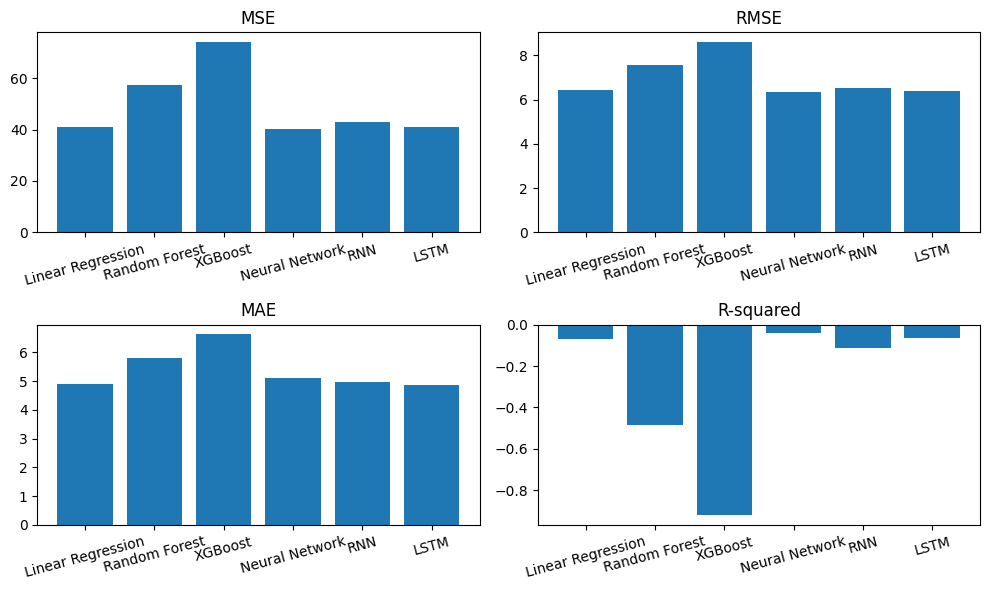

In [29]:
# Define the models as trained earlier
models = [
    ('Linear Regression', linear_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
    ('Neural Network', fnn_model),
    ('RNN',simple_rnn_model),
    ('LSTM',lstm_model)
]

# Store the evaluation results for each model
eval_results = []

# Evaluate each model and store results
for model_name, model in models:
    if model_name == 'LSTM':
        X_val_reshaped = Central_X_val.values.reshape((Central_X_val.shape[0], num_timesteps, num_features))
        mse, rmse, mae, r2 = evaluate_model(model, X_val_reshaped, Central_y_val)
    else:
        mse, rmse, mae, r2 = evaluate_model(model, Central_X_val, Central_y_val)

    eval_results.append((model_name, mse, rmse, mae, r2))

# Convert eval_results to a numpy array for plotting
eval_results = np.array(eval_results)

# Plot the evaluation metrics for each model
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(x, eval_results[:, i + 1].astype(float), tick_label=eval_results[:, 0])
    plt.title(metric)
    plt.xticks(rotation=15)
    plt.tight_layout()

plt.show()


### Hypertuning

In [30]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Create GridSearchCV instance
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Train the model using GridSearchCV
grid_search.fit(Central_X_train, Central_y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END 

LOADING DATASETS FOR CLIENTS

In [ ]:
# def dataloader(data_list, n):
#     for dataset in data_list:
#         lclid = dataset['LCLid'].iloc[0]
#         num_samples = len(dataset)

#         print(f"Loading data for LCLid {lclid}")

#         for i in range(0, num_samples, n):
#             end_idx = min(i + n, num_samples)
#             batch = dataset.iloc[i:end_idx]
#             yield batch

#         print(f"Data loading completed for LCLid {lclid}\n")

# n_samples_per_batch = 5  # Number of samples per batch

# for batch_data in dataloader(FL_train_sets_list, n_samples_per_batch):
#     print(batch_data)


FEDERATED CLIENT

In [46]:
import xgboost as xgb

import flwr as fl
from flwr.common import Metrics
from flwr.common import Weights
from flwr.common.typing import Parameters
from collections import OrderedDict
from typing import Any, Dict, List, Optional, Tuple, Union
from flwr.common import NDArray, NDArrays


# XGBoost model
def define_xgboost_model(hyperparameters: dict) -> xgb.XGBModel:
    # Hyperparameters for the XGBoost model
    model = xgb.XGBModel(**hyperparameters)
    return model

# Extract hyperparameters from `best_xgb_model` and use it to define the FLOWER client model
hyperparameters = best_xgb_model.get_xgb_params()
client_xgb_model = define_xgboost_model(hyperparameters)



ImportError: ignored

In [42]:
# Define a function to load local training data for each client
def load_local_data(client_data_list, client_index, batch_size):
    client_data = client_data_list[client_index]
    num_samples = len(client_data)

    # Calculate the starting and ending index for this client's data
    start_index = 0
    end_index = start_index + batch_size

    while start_index < num_samples:
        # Yield a batch of data
        yield client_data.iloc[start_index:end_index]

        # Move to the next batch
        start_index = end_index
        end_index = min(start_index + batch_size, num_samples)

# Example usage
client_index = 0  # Change this to select a different client
batch_size = 5   # Number of samples in each batch

# Load local training data for the selected client
for batch_data in load_local_data(FL_train_sets_list, client_index, batch_size):
    print("Loaded batch of data for client", client_index)
    print(batch_data)


Loaded batch of data for client 0
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
135       3.14   1012.97      0.83       4.76 2013-01-12  MAC000002   
115       3.20   1019.29      0.78       3.08 2013-02-08  MAC000002   
131       8.05   1033.95      0.89       1.35 2013-11-27  MAC000002   
55        6.26   1018.89      0.80       5.44 2012-12-09  MAC000002   
95        5.90   1015.79      0.79       2.61 2013-11-10  MAC000002   

     energy_sum  
135      10.586  
115       9.635  
131      11.003  
55       11.355  
95       25.556  
Loaded batch of data for client 0
     mean_temp  pressure  humidity  windSpeed       time      LCLid  \
29       6.730   1007.65      0.81       4.55 2012-12-31  MAC000002   
158      0.605   1012.85      0.78       6.06 2013-03-24  MAC000002   
51       4.470   1003.40      0.82       4.36 2012-12-04  MAC000002   
101      2.395   1010.88      0.63       3.52 2013-03-29  MAC000002   
145      7.650   1007.83      0.88       5

In [54]:
# import flwr as fl
# import xgboost as xgb

# # Define the XGBoost model
# def define_xgboost_model(hyperparameters: dict) -> xgb.XGBModel:
#     model = xgb.XGBModel(**hyperparameters)
#     return model

# # Load local training data for the client
# def load_local_data(client_data_list, client_index, batch_size):
#     client_data = client_data_list[client_index]
#     num_samples = len(client_data)
#     start_index = 0
#     end_index = start_index + batch_size

#     while start_index < num_samples:
#         yield client_data.iloc[start_index:end_index]
#         start_index = end_index
#         end_index = min(start_index + batch_size, num_samples)

# # Example usage
# client_index = 0
# batch_size = 5

# features=['mean_temp', 'pressure', 'humidity', 'windSpeed']
# target=['energy_sum']

# # Load local training data for the selected client
# for batch_data in load_local_data(FL_train_sets_list, client_index, batch_size):
#     # Create and define the client XGBoost model
#     hyperparameters = best_xgb_model.get_xgb_params()
#     client_xgb_model = define_xgboost_model(hyperparameters)

#     # Train the XGBoost model on the local data batch
#     client_xgb_model.fit(batch_data[features], batch_data[target])

#     # Get the booster object
#     booster = client_xgb_model.get_booster()

#     # Get the model's parameters
#     model_params = booster.save_config()

#     # Send the model's parameters to the server
#     fl.server.return_weights(model_params)

AttributeError: ignored

In [56]:
import flwr as fl
import xgboost as xgb

# Define the XGBoost model
def define_xgboost_model(hyperparameters: dict) -> xgb.XGBModel:
    model = xgb.XGBModel(**hyperparameters)
    return model

class XGBoostClient(fl.client.NumPyClient):
    def __init__(self, client_data, batch_size):
        self.client_data = client_data
        self.batch_size = batch_size
        self.hyperparameters = best_xgb_model.get_xgb_params()
        self.client_xgb_model = define_xgboost_model(self.hyperparameters)

    def get_parameters(self):
        booster = self.client_xgb_model.get_booster()
        model_params = booster.save_config()
        return fl.common.weights_to_parameters(model_params)

    def fit(self, parameters, config):
        model_params = fl.common.parameters_to_weights(parameters)
        booster = xgb.Booster(model_str=model_params)

        features=['mean_temp', 'pressure', 'humidity', 'windSpeed']
        target=['energy_sum']

        for batch_data in self.load_local_data(self.client_data, self.batch_size):
            self.client_xgb_model.fit(batch_data[features], batch_data[target])

        updated_model_params = self.client_xgb_model.get_booster().save_config()
        return fl.common.weights_to_parameters(updated_model_params)

    def evaluate(self, parameters, config):
        model_params = fl.common.parameters_to_weights(parameters)
        booster = xgb.Booster(model_str=model_params)

        # Evaluate the model on the local data
        # Calculate evaluation metrics
        # Return the evaluation result to the server

    def load_local_data(self, client_data, batch_size):
        num_samples = len(client_data)
        start_index = 0
        end_index = start_index + batch_size

        while start_index < num_samples:
            yield client_data.iloc[start_index:end_index]
            start_index = end_index
            end_index = min(start_index + batch_size, num_samples)

# Create a Flower client instance
client_index = 0
batch_size = 5
client_instance = XGBoostClient(FL_train_sets_list[client_index], batch_size)

# # Create a Flower client for the XGBoost model
# fl.client.start_numpy_client("[::]:8080", client=client_instance)


# Should be doing

## Gated Convolution Neural Network (GCNN)

In [34]:
# class GatedCNN24(nn.Module):
#     def __init__(self, input_channels, hidden_sizes):
#         super(GatedCNN24, self).__init__()
#         self.input_channels = input_channels
#         self.hidden_sizes = hidden_sizes

#         self.conv1 = nn.Conv2d(self.input_channels, self.hidden_sizes[0], kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(self.hidden_sizes[1], self.hidden_sizes[2], kernel_size=3, padding=1)

#         self.gate_conv1 = nn.Conv2d(self.input_channels, self.hidden_sizes[0], kernel_size=3, padding=1)
#         self.gate_conv2 = nn.Conv2d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
#         self.gate_conv3 = nn.Conv2d(self.hidden_sizes[1], self.hidden_sizes[2], kernel_size=3, padding=1)

#         self.fc1 = nn.Linear(self.hidden_sizes[2], 1)

#     def forward(self, x):
#         # Convolutional layers
#         conv1_out = self.conv1(x)
#         conv2_out = self.conv2(conv1_out)
#         conv3_out = self.conv3(conv2_out)

#         # Gating layers
#         gate_conv1_out = torch.sigmoid(self.gate_conv1(x))
#         gate_conv2_out = torch.sigmoid(self.gate_conv2(conv1_out))
#         gate_conv3_out = torch.sigmoid(self.gate_conv3(conv2_out))

#         # Element-wise multiplication (gating)
#         gated_conv1 = conv1_out * gate_conv1_out
#         gated_conv2 = conv2_out * gate_conv2_out
#         gated_conv3 = conv3_out * gate_conv3_out

#         # Sum along channels
#         gated_sum = gated_conv1 + gated_conv2 + gated_conv3

#         # Global average pooling
#         pooled = torch.mean(gated_sum, dim=[2, 3])

#         # Fully connected layer
#         output = self.fc1(pooled)
#         return output.squeeze()

# class EnergyDataset(Dataset):
#     def __init__(self, features, targets):
#         self.features = features
#         self.targets = targets

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         inputs = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
#         target = torch.tensor(self.targets.iloc[idx], dtype=torch.float32)
#         return inputs, target

# # Define hyperparameters
# input_channels = 4  # Number of features
# hidden_sizes = [10, 8, 1]
# learning_rate = 0.001
# num_epochs = 10
# batch_size = 50

# # Create DataLoader for training
# train_dataset = EnergyDataset(Central_X_train, Central_y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Create the model
# GatedCNN_model = GatedCNN24(input_channels, hidden_sizes)

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(GatedCNN_model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     GatedCNN_model.train()  # Set the model in training mode
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()

#         # Reshape the input tensor to match expected shape [batch_size, channels, height, width]
#         inputs = inputs.view(inputs.size(0), input_channels, 1, 1)

#         outputs = GatedCNN_model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


## Gated Neural Network model

In [35]:
# # Build the Gated Neural Network model
# inputs = Input(shape=(4,))
# dense_layer = Dense(16, activation='relu')(inputs)

# # Gating mechanism
# dense_gate = Dense(16, activation='sigmoid')(inputs)
# gated_dense = Multiply()([dense_layer, dense_gate])

# output = Dense(1, activation='linear')(gated_dense)

# GNN_model = Model(inputs=inputs, outputs=output)

# # Compile the model
# GNN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# # Train the model
# GNN_model.fit(Central_X_train, Central_y_train, epochs=10, batch_size=32, validation_split=0.2)

Implementing FLower Client

In [36]:
# import flwr as fl

# from flwr.client import NumPyClient
# import xgboost as xgb
# from sklearn.metrics import accuracy_score
# import io

# class XGBoostClient(fl.client.NumPyClient):
#     def __init__(self, model, X_train, y_train, X_val, y_val):
#         self.model = model
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_val = X_val
#         self.y_val = y_val

#     def get_parameters(self, config=None):
#         with io.BytesIO() as buffer:
#             self.model.save_model(buffer)
#             return buffer.getvalue()

#     def fit(self, parameters, config):
#         new_model = xgb.XGBRegressor(**config)
#         with io.BytesIO(parameters) as buffer:
#             new_model.load_model(buffer)
#         self.model = new_model

#         self.model.fit(self.X_train, self.y_train)

#         with io.BytesIO() as buffer:
#             self.model.save_model(buffer)
#             return buffer.getvalue()

#     def evaluate(self, parameters, config):
#         new_model = xgb.Booster(params=config, model_str=parameters[0])
#         self.model = new_model

#         y_pred = self.model.predict(self.X_val)
#         accuracy = accuracy_score(self.y_val, y_pred)

#         return accuracy



In [37]:
# # the best hyperparameters in best_xgb_model
# best_hyperparameters = best_xgb_model.get_xgb_params()

# # Create an instance of your XGBoost model with the best hyperparameters
# best_xgb_model_instance = xgb.XGBRegressor(**best_hyperparameters)


# # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
# client_resources = None
# if DEVICE.type == "cuda":
#     client_resources = {"num_gpus": 1}

# # Define a function to create a virtual client
# def create_virtual_client(lclid):
#     client_data = FL_train_set[FL_train_set['LCLid'] == lclid]
#     X_client = client_data[['mean_temp', 'pressure', 'humidity', 'windSpeed']]
#     y_client = client_data['energy_sum']
#     return XGBoostClient(best_xgb_model_instance, X_client, y_client,  FL_test_set[['mean_temp', 'pressure', 'humidity', 'windSpeed']], FL_test_set['energy_sum'])

# # Fit the XGBoost model before creating virtual clients
# best_xgb_model_instance.fit(Central_X_train, Central_y_train)

# # Create a list of virtual clients
# virtual_clients = [create_virtual_client(lclid) for lclid in unique_lclids]

# # Define the client function for Flower simulation
# def client_fn(cid: str) -> XGBoostClient:
#     virtual_client = virtual_clients[int(cid)]
#     return virtual_client

# # Define the Flower simulation configuration
# config = fl.server.ServerConfig(num_rounds=5)

# # Start the Flower simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=len(virtual_clients),
#     config=config,
#     strategy=fl.server.strategy.FedAvg(),
#     client_resources=None,  # Adjust client resources as needed
# )
